In [33]:
from langchain.memory import summary
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import START, END
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from operator import add
import requests
from datetime import datetime
from serpapi import GoogleSearch
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.tools import tool
from trustcall import create_extractor
from typing import TypedDict, Literal
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage, ToolMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from IPython.display import Markdown, Image, display
from dotenv import dotenv_values
from pypdf import PdfReader
import json
import pandas as pd
import os

from typing_extensions import Optional

In [34]:
env_values = {**dotenv_values(".env.shared"), **dotenv_values(".env.secret")}

os.environ["LANGSMITH_TRACING"] = env_values["LANGSMITH_TRACING"]
os.environ["LANGSMITH_ENDPOINT"] = env_values["LANGSMITH_ENDPOINT"]
os.environ["LANGSMITH_API_KEY"] = env_values["LANGSMITH_API_KEY"]
os.environ["LANGSMITH_PROJECT"] = env_values["LANGSMITH_PROJECT"]
os.environ["OPENAI_API_KEY"] = env_values["OPENAI_API_KEY"]

## Summarization graph

In [ ]:
PATH_TO_FILES = "./Data"

In [ ]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

def read_docs():
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return text

In [ ]:
test = read_docs()

In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.4, top_p=0.38)

In [ ]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Ignore any IDs"),
    ("human", "Summarize this {input}")
])

In [ ]:
runnable_summarization = summarization_prompt | llm

In [ ]:
output = runnable_summarization.invoke({'input': test}).content

In [ ]:
Markdown(output)

### Creation of the summary graph

In [35]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, top_p=0.38)

#### States

In [36]:
class SummaryGraphInput(TypedDict):
    summary: str
    text: str

class SummaryGraphOutput(TypedDict):
    summary_graph: str


#### Utils

In [37]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

#### Prompts

In [38]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Add the employee IDs also. Ignore any other IDs. Do not provide the output in any font or styles. Provide the summary in a neat structured format."),
    ("human", "Summarize this {input}")
])

#### Nodes

In [39]:
def read_docs(state: SummaryGraphInput):
    PATH_TO_FILES = "./Data"
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return {'text': text}

In [40]:
def summarize(state: SummaryGraphInput):
    text = state['text']
    runnable_summarization = summarization_prompt | llm
    output = runnable_summarization.invoke({'input': text}).content
    with open("./summary/summary.txt", "w") as f:
        f.write(output)
    return {'summary_graph': output}

In [41]:
graph_summarizer_builder = StateGraph(SummaryGraphInput, output=SummaryGraphOutput)

graph_summarizer_builder.add_node("read documents", read_docs)
graph_summarizer_builder.add_node("summarize documents", summarize)

graph_summarizer_builder.add_edge(START, "read documents")
graph_summarizer_builder.add_edge("read documents", "summarize documents")
graph_summarizer_builder.add_edge("summarize documents", END)

memory = MemorySaver()
graph_summarizer = graph_summarizer_builder.compile()

In [ ]:
display(Image(graph_summarizer.get_graph().draw_mermaid_png()))

In [ ]:
Markdown(graph_summarizer.invoke({}, config={'configurable': {'thread_id': "summarizer_4"}})['summary_graph'])

## Travel Agent AI

### Creation of the graph

#### Output Formats

In [171]:
class Profile(BaseModel):
    travel_history: str = Field(description="The travel history of the employee.")
    preferences: str = Field(description="The preferences s (airlines, hotels, window/aisle, meal choice, etc.) of the employee.")
    role_specific_permissions: str = Field(description="The roles specific to this employee.")
    likes: str | None = Field(description="The likes of the employee.")
    dislikes: str | None = Field(description="The dislikes of the employee.")
    flight: str | None = Field(description="The flight details of the flight which the employee is taking.")
    hotel: str | None = Field(description="The hotel which the employee is staying.")

class TravelRequirements(BaseModel):
    destination: str = Field(description="The destination of travel the employee.")
    source: str | None = Field(description="The place from which the employee will start travelling")
    purpose: Literal['leisure', 'business'] = Field(description="The purpose of travel the employee.")
    date_of_departure: str = Field(description="The date of departure of the employee.")
    date_of_arrival: str = Field(description="The date of arrival of the employee.")
    duration: str = Field(description="The duration of travel the employee.")

class OrganizationalRules(BaseModel):
    travel_budgets: str = Field(description="The travel budgets of the organization for each cadre of employee")
    approval_hierarchies: str= Field(description="The approval hierarchies for each employee.")
    preferred_vendors: str = Field(description="The preferred vendors for the organization.")
    visa_requirements: str = Field(description="The type of visa requirements for the travel.")

class Traveller(BaseModel):
    name: str = Field(description="The name of the employee.")
    employee_id: str = Field(description="The ID of the employee.")
    profile: Profile = Field(description="The profile of the employee.")
    travel_requirements: TravelRequirements = Field(description="The travel requirements for the employee.")
    organizational_rules: OrganizationalRules = Field(description="The organizational rules for the employee.")

class Travellers(BaseModel):
    travellers: list[Traveller] = Field(description="The list of travellers.")


In [172]:
from pprint import pprint

In [173]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

trustcall_extractor = create_extractor(
    llm,
    tools=[Travellers],
    tool_choice="Travellers"
)

In [ ]:
with open("./summary/summary.txt", "r") as f:
    data = f.read()

In [ ]:
system_msg = "Extract the profiles of all employees from the given data. {data}"
trustcaller_system_message = SystemMessage(content=system_msg.format(data=data))

In [ ]:
result = trustcall_extractor.invoke({"messages": [trustcaller_system_message]})

In [ ]:
schema = result['responses']

In [ ]:
schema[0].model_dump()

In [ ]:
travellers =  result["messages"][0].tool_calls[0]['args']['travellers']

In [ ]:
in_mem_store = InMemoryStore()


for traveller in travellers:
    key = traveller.get("employee_id", None)
    if key is not None:
        namespace = ("memory", key.lower())
        in_mem_store.put(namespace, "traveler", traveller)


In [ ]:
for m in in_mem_store.search(("memory", "1001")):
    pprint(m)

#### States

In [43]:
class TravelAgent(MessagesState):
    profile: Traveller
    output: str
    prompt: str
    summary: str
    flight_data: str
    hotel_data: str
    weather_data: str
    summary_graph: str
    user_specification: str

In [44]:
class ToolCalls(TypedDict):
    tools: Literal['flight', 'traffic', 'weather', 'hotel']

#### Prompts

#### Create Nodes

In [45]:
def add_travellers(state: TravelAgent, store:BaseStore):
    with open("./summary/summary.txt", "r") as f:
        data = f.read()
    trustcall_extractor = create_extractor(
    llm,
    tools=[Travellers],
    tool_choice="Travellers")
    system_msg = "Extract the profiles of all employees from the given data. {data}"
    trustcaller_system_message = SystemMessage(content=system_msg.format(data=data))
    result = trustcall_extractor.invoke({"messages": [trustcaller_system_message]})
    travellers =  result["messages"][0].tool_calls[0]['args']['travellers']
    for traveller in travellers:
        key = traveller.get("employee_id", None)
        if key is not None:
            namespace = ("memory", key.lower())
            store.put(namespace, "traveler", traveller)
    return state


In [68]:
def read_profile(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    id = config['configurable']['user_id']
    namespace = ("memory", id)
    user_specification = state.get('user_specification')
    profile = store.get(namespace, "traveler")
    if user_specification is not None and profile is not None:
        extractor = create_extractor(
            llm,
            tools=[Traveller],
            tool_choice="Traveller"
        )
        result = extractor.invoke({"messages": [("system", "Update the travel specification."), ("human", user_specification)], 'existing': {"Traveller": profile}})
        updated_profile = result['responses'][0].model_dump()
        state['profile'] = updated_profile
        store.put(namespace, "traveller", updated_profile)
        return state
    state['profile'] = profile.value
    print(f"PROFILE:{profile.value}")
    return state

In [69]:
def to_create_profile(state: TravelAgent, store: BaseStore, config: RunnableConfig):
    file_path = "./summary/summary.txt"
    if os.path.exists(file_path) and os.stat(file_path).st_size == 0:
        return "summary graph"
    elif not store.search(('memory', config['configurable']['user_id'])):
        return "add travellers"
    else:
        return "read profile"

In [70]:
def check_profiles(state: TravelAgent):
    profile = state['profile']
    if profile is None:
        return END
    else:
        return "chatbot"


In [124]:
def route_ai(state: TravelAgent):
    messages = state['messages']
    count = 0
    for message in messages:
        if isinstance(message, AIMessage) and count < 10:
            if message.content:
                count += 1
    print(count)
    if count >= 10:
        return "summarizer and updater"
    else:
        return END

In [125]:
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation only if necessary. Do not change the organization rules. If no changes are necessary then return None"""

In [126]:
def summarizer_and_updater(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    messages = state['messages']
    summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant, who helps in summarizing the conversation.
    Conversation: {messages}"""),
    ("human", "Summarize the conversation")
])
    runnable_summarizer = summarization_prompt | llm
    extractor = create_extractor(
        llm,
        tools=[Traveller],
        tool_choice="Traveller"
    )
    summary = state.get('summary', "")
    output = runnable_summarizer.invoke({'messages': messages}).content
    summary += output
    deleted_messages = [RemoveMessage(id=message.id) for message in messages[:-4]]
    profile = state['profile']
    json_profile = {"Traveller": profile}

    result = extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + messages, 'existing': json_profile})
    updated_profile = result['responses'][0].model_dump()
    store.put(("memory", config['configurable']['user_id']), 'traveler', updated_profile)
    state['summary'] = summary
    state['messages'] = deleted_messages
    return state

In [176]:
chatbot_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Help answer questions based on the profile. Analyze the profile and give relevant suggestions according to the profile.
    The order of precedence for suggestions is likes, dislikes and then preferences. Adhere to the organizational rules for budget and other corporate matters.
    The itinerary must be in a well structured format with the most likely to visit places first. Do not provide more than 5 suggestions. Take into account if there is any meetings when providing the time for leisure activities. You are essentially a travel concierge.
    If there is some ambiguity in the question posed by the user, analyze the history to make some inferences, if that also does not work then ask a follow up question to rectify the ambiguity.
    Behave like a concierge, providing follow up suggestions after providing the answer. Provide emoji's in the output.

    Tool Call Instructions:
    Analyze the travel requirements carefully.
    To retrieve the flight data, use the flight_data tool call. The parameters of this tool, must first be generated from the prompt and then the travel requirements in the profile, and then if there is some ambiguity, clarify with the user. Use the current date and time to make real time booking suggestions. Make sure to adhere to all the organizational rules. When using departure token provide all the details including the departure token. If there are no flights, for the given query, then provide that as output and ask the user for clarification. For the return flight, unless the user specifies, use the date of departure as outbound date and keep the arrival date from 1-2 days from the outbound date.

    To get hotel data, use the get_hotel_data tool, and all the parameters to this tool must be acquired from the prompt and the travel requirements and the user preferences and the organizational rules. Any ambiguity present, clarify with the user.

    To get weather data, use the get_weather tool to get real time weather data. This tool can also forecast the weather for upto 3 days. Use this tool to account for the weather when generating itinerary, places to visit etc. if asked by the user. If the user asks to find the weather use this tool directly.

    Action Instructions:
    If for some reason a flight is canceled use the get_flight_data tool to get flight data, with the same arrival and departure id but new dates.
    Do the same for hotel rebooking also by using get_hotel_data tool.


    Answer questions only related to travelling.
    Use the current date and time for real time suggestions. This is the current date and time: {date_time}
    Summary of the conversation (can be empty also): {summary}
    Reply from the tools for tool calls(can be empty also). If the reply from the tools is 'There are no such flights for the given criteria.' Then return do not perform any more tool calls: {reply}
    If there is a reply from the tool calls, then provide the output based on the reply from the tool.
    Profile: {profile}
    Organization Rules: {organization}
    Travel Requirements: {travel_requirements}
    """),
    ("placeholder", "{messages}"),
    ("human", "{input}")

])

In [177]:
def chatbot(state: TravelAgent):
    prompt = state['prompt']
    summary = state.get('summary', "")
    profile = state['profile']
    messages = state['messages']
    date_time = datetime.now()
    formatted_date_time = date_time.strftime("%Y-%m-%d %H:%M:%S")
    reply = state.get("flight_data", "")
        # print("Inside")
    last_instance = messages[-1]
    if isinstance(last_instance, ToolMessage):
        if messages[-2].tool_calls[0]['name'] == "get_flight_data":
            if  "error" not in last_instance.content.lower():
                reply = last_instance.content
                if 'There are no such flights for the given criteria.' in reply:
                    state['output'] = reply
                    state['messages'] = [("ai", reply)]
                    return state
                state['flight_data'] = reply
        elif messages[-2].tool_calls[0]['name'] == "get_hotel_data":
            reply = last_instance.content
            state['hotel_data'] = reply
        elif messages[-2].tool_calls[0]['name'] == "get_weather":
            reply = last_instance.content
            state['weather_data'] = reply

        messages.pop()
        messages.pop()
    # print(summary)
    runnable_chatbot = chatbot_prompt | llm.bind_tools(tools, parallel_tool_calls=False)
    output = runnable_chatbot.invoke({'input': prompt, 'summary': summary, "profile": str({"name": profile['name'] , "profile":profile['profile']}), "reply": reply, 'messages': messages, 'date_time': formatted_date_time, 'organization': profile['organizational_rules'], 'travel_requirements': profile['travel_requirements']})
    state['output'] = output.content
    state['messages'] = [output]
    return state

In [178]:
def route_to_update(state: TravelAgent):
    prompt = state['prompt']
    system_msg = "If the user provides some personal preferences, likes or dislikes, or something related to travel requirements such as destination, duration of the trip, type of trip, flight taken, hotel staying at, etc. then return 'true', else return 'false'. Do not provide any explanations."
    template = ChatPromptTemplate.from_messages([
        ("system", system_msg),
        ("human", prompt)
    ])
    runnable_template = template | llm
    output = runnable_template.invoke({}).content
    if "true" in output:
        return "update profile"
    else:
        return END

In [199]:
def update_profile(state: TravelAgent, store:BaseStore):
    prompt = state['prompt']
    profile = state['profile']
    json_profile = {"Traveller": profile}

    trustcall_system_msg = "Update the profile based on based on the prompt. Update the dates if the user specifies a date. Update the places of stay and the flight taken also if needed."
    extractor = create_extractor(
        llm,
        tools=[Traveller],
        tool_choice='Traveller',
    )
    flight = profile.get('flight')
    hotel = profile.get('hotel')
    if flight is not None and hotel is not None:
        result = extractor.invoke({'messages':[("system", trustcall_system_msg),("human", prompt + state['flight_data'] + "Save the flight number" + state['hotel_data'])], 'existing': json_profile})
    elif flight is not None:
        result = extractor.invoke({'messages':[("system", trustcall_system_msg),("human", prompt + state['flight_data'] + "Save the flight number")], 'existing': json_profile})
    elif hotel is not None:
        result = extractor.invoke({'messages':[("system", trustcall_system_msg),("human", prompt + state['hotel_data'])], 'existing': json_profile})
    else:
        result = extractor.invoke({'messages':[("system", trustcall_system_msg),("human", prompt)], 'existing': json_profile})

    updated_profile = result['responses'][0].model_dump()
    store.put(("memory", config['configurable']['user_id']), 'traveler', updated_profile)
    state['profile'] = updated_profile
    return state


In [200]:
@tool
def get_flight_data(departure_city:str, arrival_city:str, return_date:str | None, outbound_date:str, currency:str="USD", type:str="2", travel_class:str="1", multi_city_json:str=None, adults:str="1", children:str="0", sort_by:str="1", stops:str="0", return_times:str=None, layover_duration:str=None, max_price:str=None, departure_token:str=None) -> dict:
    """
    Fetch flight details using SerpAPI.

    Parameters:
    departure_id (str): Name of the departure city in IATA code (e.g., 'New York').
    arrival_id (str): Name of the arrival city in IATA code (e.g., 'London').
    retrun_date (str | None): Return date in YYYY-MM-DD format.
    outbound_date (str): Departure date in YYYY-MM-DD format.
    currency (str): Parameter defines the currency of the returned prices.
    type (str): Parameter defines the type of the flights. Available options:

        1 - Round trip (default)
        2 - One way
        3 - Multi-city


    travel_class (str): Parameter defines the travel class.
            Available options:
            1 - Economy (default)
            2 - Premium economy
            3 - Business
            4 - First

    multi_city_json (dict): Parameter defines the flight information for multi-city flights. It's a JSON string containing multiple flight information objects. Each object should contain the following fields:

departure_id - The departure airport code or location kgmid. The format is the same as the main departure_id parameter.
arrival_id - The arrival airport code or location kgmid. The format is the same as the main arrival_id parameter.
date - Flight date. The format is the same as the outbound_date parameter.
times - Time range for the flight. The format is the same as the outbound_times parameter. This parameter is optional.

Example:
[{"departure_id":"CDG","arrival_id":"NRT","date":"2025-04-01"},{"departure_id":"NRT","arrival_id":"LAX,SEA","date":"2025-04-08"},{"departure_id":"LAX,SEA","arrival_id":"AUS","date":"2025-04-15","times":"8,18,9,23"}]

    adults (str): Number of adults
    children (str): Number of children
    sort_by (str): Parameter defines the sorting order of the results.
            Available options:

            1 - Top flights (default)
            2 - Price
            3 - Departure time
            4 - Arrival time
            5 - Duration
            6 - Emissions
    stops (str): Parameter defines the number of stops during the flight.
                Available options:

                0 - Any number of stops (default)
                1 - Nonstop only
                2 - 1 stop or fewer
                3 - 2 stops or fewer
    max_price (str): Maximum price of the ticket.
    return_times (str): Parameter defines the return times range. It's a string containing two (for departure only) or four (for departure and arrival) comma-separated numbers. Each number represents the beginning of an hour. For example:

        4,18: 4:00 AM - 7:00 PM departure
        0,18: 12:00 AM - 7:00 PM departure
        19,23: 7:00 PM - 12:00 AM departure
        4,18,3,19: 4:00 AM - 7:00 PM departure, 3:00 AM - 8:00 PM arrival
        0,23,3,19: unrestricted departure, 3:00 AM - 8:00 PM arrival

    layover_duration (str): Parameter defines the layover duration, in minutes. It's a string containing two comma-separated numbers. For example, specify 90,330 for 1 hr 30 min - 5 hr 30 min.

    departure_token (str): Used to get details of the return flight

    Returns:
    dict: Flight details if available, else an error message.

    """
    cities_iata = {
    "new york": "JFK",
    "los angeles": "LAX",
    "chicago": "ORD",
    "san francisco": "SFO",
    "dallas": "DFW",
    "miami": "MIA",
    "atlanta": "ATL",
    "london": "LHR",
    "paris": "CDG",
    "tokyo": "HND",
    "dubai": "DXB",
    "singapore": "SIN",
    "hong kong": "HKG",
    "sydney": "SYD",
    "toronto": "YYZ",
    "frankfurt": "FRA",
    "amsterdam": "AMS",
    "madrid": "MAD",
    "beijing": "PEK",
    "seoul": "ICN",
    "bangkok": "BKK",
    "rome": "FCO",
    "istanbul": "IST",
    "são paulo": "GRU",
    "mexico city": "MEX",
    "moscow": "SVO",
    "delhi": "DEL",
    "mumbai": "BOM",
    "shanghai": "PVG",
    "johannesburg": "JNB",
    "bangalore": "BLR",
    "berlin": "BER",
}

    departure_id = cities_iata.get(departure_city.lower(), departure_city)
    arrival_id = cities_iata.get(arrival_city.lower(), arrival_city)


    params = {
        "engine": "google_flights",
        "departure_id": departure_id,
        "arrival_id": arrival_id,
        "return_date": return_date,
        "outbound_date": outbound_date,
        "api_key": env_values["SERP_API_KEY"],
        "currency": currency,
        "type": type,
        "travel_class": travel_class,
        "multi_city_json": multi_city_json,
        "adults": adults,
        "children": children,
        "sort_by": sort_by,
        "max_price": max_price,
        "return_times": return_times,
        "layover_duration": layover_duration,
        "stops": stops,
        "departure_token": departure_token
    }

    try:
        search = GoogleSearch(params)
        results = search.get_dict()
        results = results['best_flights'][:10]
        print(results)
        cleaned_flights = [clean_flight_data(flight) for flight in results]
        tidy_json = json.dumps(cleaned_flights, indent=4)
        # print(tidy_json)
        return tidy_json
    except Exception as e:
        return "There are no such flights for the given criteria."


In [201]:
def clean_flight_data(flight_data):
    # Remove airline_logo and departure_token from the top-level dictionary
    # flight_data.pop('departure_token', None)
    flight_data.pop('airline_logo', None)

    # Iterate through flights and remove airline_logo from each flight
    for flight in flight_data.get('flights', []):
        flight.pop('airline_logo', None)

    return flight_data

In [202]:
# get_flight_data("BLR", "DXB", "2025-03-29", "2025-03-27")

In [203]:
@tool
def get_hotel_data(location: str, checkin_date: str, checkout_date: str, adults:str="1", children:str="0",
                   rating:str="8", hotel_class:str="4"):
    """
    Fetches hotel data from Google Hotels using SerpAPI.

    :param location: City or location name
    :param checkin_date: Check-in date in YYYY-MM-DD format
    :param checkout_date: Check-out date in YYYY-MM-DD format
    :param adults: Number of adults
    :param children: Number of children
    :param rating: Hotel rating
    :param hotel_class: The number of stars of the hotel
    :return: List of hotels with their details
    """
    params = {
        "engine": "google_hotels",
        "q": location,
        "check_in_date": checkin_date,
        "check_out_date": checkout_date,
        "api_key": env_values["SERP_API_KEY"],
        "adults": adults,
        "children": children,
        "rating": rating,
        "hotel_class": hotel_class,
    }

    response = GoogleSearch(params)
    data = response.get_dict()

    hotels = []
    # print(data)

    if "properties" in data:
        for hotel in data["properties"]:
            hotels.append({
                "name": hotel.get("name"),
                "price": hotel.get("rate_per_night"),
                "description": hotel.get("description"),
                "ratings": hotel.get("overall_rating"),
                "stars": hotel.get("hotel_class"),
                "check_in_time": hotel.get("check_in_time"),
                "check_out_time": hotel.get("check_out_time"),
                "link": hotel.get("link"),
            })
            # hotels.append(hotel)
    else:
        hotels = "No results found."

    return hotels



In [204]:
@tool
def get_weather(city, days):
    """
    Get weather from weather API.
    :param city: The city name.
    :param days: The number of days to forecast
    :return: weather data.
    """
# URLs for current weather and forecast
    API_KEY = env_values['WEATHERAPI_KEY']
    CURRENT_URL = f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q={city}&aqi=no"
    FORECAST_URL = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city}&days={days}&aqi=no&alerts=no"

    output = ""
    # Fetch Current Weather
    current_response = requests.get(CURRENT_URL)
    if current_response.status_code == 200:
        current_data = current_response.json()
        current_temp = current_data["current"]["temp_c"]
        condition = current_data["current"]["condition"]["text"]
        output += f"Current Weather in {city}: {current_temp}°C, {condition}\n"
    else:
        output +=  f"Error fetching current weather: {current_response.status_code}, {current_response.text}"

    # Fetch Forecast Weather
    forecast_response = requests.get(FORECAST_URL)
    if forecast_response.status_code == 200:
        forecast_data = forecast_response.json()

        print("\nForecast:")
        for day in forecast_data["forecast"]["forecastday"]:
            date = day["date"]
            max_temp = day["day"]["maxtemp_c"]
            min_temp = day["day"]["mintemp_c"]
            condition = day["day"]["condition"]["text"]
            output += f"{date}: {condition}, {min_temp}-{max_temp}°C"
    else:
        output += f"Error fetching forecast: {forecast_response.status_code}, {forecast_response.text}"

    return output


In [205]:
tools = [get_flight_data, get_hotel_data, get_weather]

In [206]:
tools_node = ToolNode(tools)

In [187]:
graph_chatbot_builder = StateGraph(TravelAgent)

graph_chatbot_builder.add_node("read profile", read_profile)
graph_chatbot_builder.add_node("summary graph", graph_summarizer)
graph_chatbot_builder.add_node("add travellers", add_travellers)
graph_chatbot_builder.add_node("chatbot", chatbot)
graph_chatbot_builder.add_node("summarizer and updater", summarizer_and_updater)
graph_chatbot_builder.add_node("tools", tools_node)
graph_chatbot_builder.add_node("update profile", update_profile)

graph_chatbot_builder.add_conditional_edges(START, to_create_profile, ['summary graph', 'read profile', "add travellers"])
graph_chatbot_builder.add_edge("summary graph", "add travellers")
graph_chatbot_builder.add_edge("add travellers", "read profile")
graph_chatbot_builder.add_conditional_edges("read profile", check_profiles, ["chatbot", END])
graph_chatbot_builder.add_conditional_edges("chatbot", route_ai, ["summarizer and updater", END])
graph_chatbot_builder.add_conditional_edges("chatbot", tools_condition)
graph_chatbot_builder.add_conditional_edges("chatbot", route_to_update, ["update profile", END])
graph_chatbot_builder.add_edge("tools", "chatbot")
graph_chatbot_builder.add_edge("summarizer and updater", END)
graph_chatbot_builder.add_edge("update profile", END)

memory = MemorySaver()
store = InMemoryStore()
graph_chatbot = graph_chatbot_builder.compile(checkpointer=memory, store=store, debug=False)

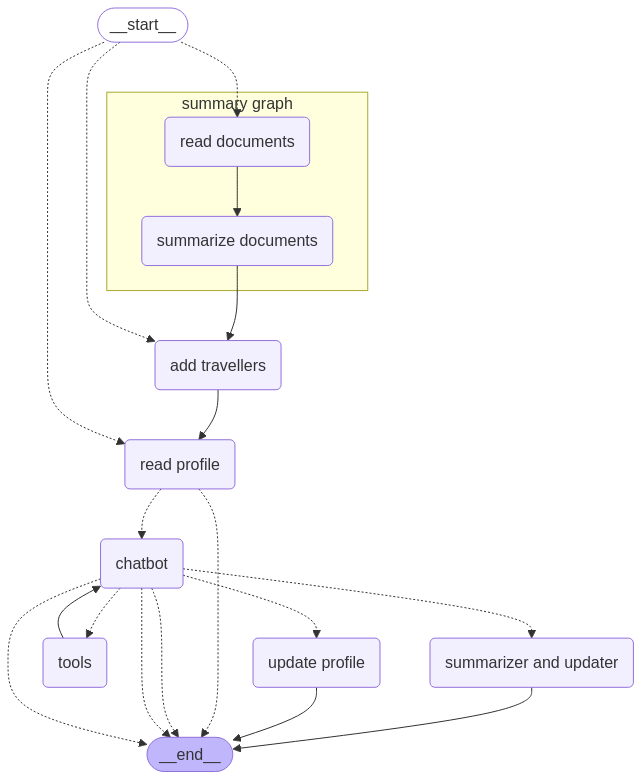

In [122]:
display(Image(graph_chatbot.get_graph(xray=1).draw_mermaid_png()))

In [188]:
config = {'configurable': {'thread_id': "chatbot-new-70", "user_id": "1001"}}

In [197]:
# for _ in range(3):
user_input = input()
test = graph_chatbot.invoke({"prompt": user_input, "messages": [("human", user_input)]}, config=config)
    # print(test['output'])

PROFILE:{'name': 'Carol Lee', 'employee_id': '1003', 'profile': {'travel_history': 'Singapore, Japan (1x)', 'preferences': 'Preferred Airlines: Singapore Airlines; Preferred Hotels: 5-star; Meal Preference: Non-Veg; Seat Preference: Aisle', 'role_specific_permissions': 'Data Scientist', 'likes': None, 'dislikes': None, 'flight': 'Japan Airlines', 'hotel': None}, 'travel_requirements': {'destination': 'Tokyo', 'source': 'Bangalore', 'purpose': 'business', 'date_of_departure': '2025-09-10', 'date_of_arrival': '2025-09-20', 'duration': '10 days'}, 'organizational_rules': {'travel_budgets': 'Max budget per trip per employee: $3,000 (Region dependent)', 'approval_hierarchies': 'Approval from direct manager required for travel abroad', 'preferred_vendors': 'Preferred airline partners: Lufthansa, Emirates, Delta; Hotels must be 5-star for company bookings', 'visa_requirements': 'Visa approval must be completed before flight booking'}}
5


In [198]:
Markdown(test['output'])

Staying at the Hyatt Regency Tokyo offers you a great location to explore some of Tokyo's most iconic attractions. Here are some places you might want to visit nearby:

1. **Shinjuku Gyoen National Garden** 🌳
   - **Distance:** Approximately 1.5 km
   - **Description:** A beautiful and expansive park featuring traditional Japanese gardens, a greenhouse, and cherry blossoms in spring.

2. **Tokyo Metropolitan Government Building** 🏢
   - **Distance:** Approximately 0.5 km
   - **Description:** Offers free observation decks with panoramic views of Tokyo, including Mount Fuji on clear days.

3. **Meiji Shrine** ⛩️
   - **Distance:** Approximately 3 km
   - **Description:** A serene Shinto shrine surrounded by a lush forest, dedicated to Emperor Meiji and Empress Shoken.

4. **Omoide Yokocho (Memory Lane)** 🍜
   - **Distance:** Approximately 1 km
   - **Description:** A narrow alleyway filled with small eateries offering traditional Japanese dishes like yakitori and ramen.

5. **Tokyo Opera City** 🎶
   - **Distance:** Approximately 1.5 km
   - **Description:** A cultural complex with a concert hall, art gallery, and various dining options.

These attractions offer a mix of cultural, historical, and modern experiences, all within a short distance from your hotel. Enjoy your stay and exploration in Tokyo! If you need more information or assistance, feel free to ask. 😊

In [ ]:
# test['messages'][-3].tool_calls[0]['name']

In [ ]:
Gin_mem_store.get(("memory", "1001"), "traveler")

In [ ]:
# def get_coordinates(place_name):
#     """Convert place name to latitude and longitude using TomTom Geocoding API."""
#     API_KEY= env_values['TOM_API_KEY']
#     geo_url = f"https://api.tomtom.com/search/2/geocode/{place_name}.json?key={API_KEY}"
#     response = requests.get(geo_url)
#     data = response.json()
#
#     if "results" in data and len(data["results"]) > 0:
#         location = data["results"][0]["position"]
#         return location["lat"], location["lon"]
#     else:
#         print(f"Location not found: {place_name}")
#         return None, None
#
# def get_traffic_between_places(origin, destination):
#     """Fetch real-time traffic data between two places."""
#     lat1, lon1 = get_coordinates(origin)
#     lat2, lon2 = get_coordinates(destination)
#
#     if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
#         return
#
#     # TomTom Routing API with Traffic Data
#     route_url = f"https://api.tomtom.com/routing/1/calculateRoute/{lat1},{lon1}:{lat2},{lon2}/json?key={API_KEY}&traffic=true"
#
#     response = requests.get(route_url)
#     route_data = response.json()
#
#     if "routes" in route_data:
#         route = route_data["routes"][0]["summary"]
#         print(f"Traffic Data Between {origin} and {destination}:")
#         print(f"  Distance: {route['lengthInMeters'] / 1000:.2f} km")
#         print(f"  Estimated Time: {route['travelTimeInSeconds'] // 60} min")
#         print(f"  Traffic Delay: {route['trafficDelayInSeconds'] // 60} min")
#     else:
#         print("No route data available.")
#
# # Example Usage
# origin = "Banaswadi, Banglore"
# destination = "Koramangala, Banglore"
# get_traffic_between_places(origin, destination)

In [356]:
from langgraph_sdk import get_client
import asyncio

In [357]:
url = "http://localhost:8124"

In [358]:
client = get_client(url=url)

In [359]:
thread = await client.threads.create()

In [360]:
thread

{'thread_id': 'dbbaebc1-e979-45ed-b800-d8aa7e6bcd43',
 'created_at': '2025-03-27T14:37:31.351873+00:00',
 'updated_at': '2025-03-27T14:37:31.351873+00:00',
 'metadata': {},
 'status': 'idle',
 'config': {},
 'values': None,
 'interrupts': {}}

In [361]:
user_input = "Give me some flight suggestions from Banglore to Berlin for 1 person on the on 2025-07-03 for 5 days in business class"
config = {'configurable': {"thread_id": "test-server", 'user_id': "1001"}}
graph_name = "chatbot"

In [368]:
user_input = input()

In [369]:
run = await client.runs.create(thread['thread_id'], graph_name, input={"prompt": user_input, "messages": [("human", user_input)]}, config=config, multitask_strategy="interrupt")

In [370]:
output = await client.runs.join(thread['thread_id'], run["run_id"])

In [371]:
Markdown(output['output'])

Here are some alternative 4-star hotel suggestions in Berlin:

1. **Mercure Hotel Berlin Wittenbergplatz**
   - **Price:** $128 per night
   - **Description:** Plush rooms in a contemporary hotel offering a modern restaurant/bar & a hip lounge.
   - **Ratings:** 4.6
   - **Check-in Time:** 12:00 AM
   - **Check-out Time:** 12:00 AM
   - [More Info](https://all.accor.com/lien_externe.svlt?goto=fiche_hotel&code_hotel=9147&merchantid=seo-maps-DE-9147&sourceid=aw-cen&utm_medium=seo%20maps&utm_source=google%20Maps&utm_campaign=seo%20maps)

2. **Crowne Plaza Berlin City Centre**
   - **Price:** $126 per night
   - **Description:** Sophisticated lodging with free Wi-Fi, dining & 2 bars, plus a spa with an indoor pool & a sauna.
   - **Ratings:** 4.4
   - **Check-in Time:** 3:00 PM
   - **Check-out Time:** 12:00 PM
   - [More Info](https://www.ihg.com/crowneplaza/hotels/gb/en/berlin/bercc/hoteldetail?cm_mmc=GoogleMaps-_-CP-_-DE-_-BERCC)

3. **Hotel NH Collection Berlin Mitte am Checkpoint Charlie**
   - **Price:** $120 per night
   - **Description:** Airy, modern hotel offering a spa with a rooftop relaxation area, plus terrace dining & free Wi-Fi.
   - **Ratings:** 4.4
   - **Check-in Time:** 12:00 PM
   - **Check-out Time:** 12:00 PM
   - [More Info](https://www.nh-hotels.com/en/hotel/nh-collection-berlin-mitte-checkpoint-charlie?utm_campaign=local-gmb&utm_medium=organic_search&utm_source=google_gmb)

4. **Estrel Berlin**
   - **Price:** $121 per night
   - **Description:** Sprawling contemporary lodging with 5 restaurants, 3 bars & a spa, plus a waterfront garden.
   - **Ratings:** 4.4
   - **Check-in Time:** 3:00 PM
   - **Check-out Time:** 10:00 AM
   - [More Info](https://www.estrel.com/)

5. **centrovital**
   - **Price:** $100 per night
   - **Description:** Refined rooms & suites in a classy spa hotel with a lake-view restaurant & a bistro/bar.
   - **Ratings:** 4.3
   - **Check-in Time:** 3:00 PM
   - **Check-out Time:** 11:00 AM
   - [More Info](https://www.centrovital-berlin.de/#gbp)

These options should meet your needs for a comfortable stay in Berlin. Let me know if you need further assistance! 🏨✨

In [366]:
thread_alert = await client.threads.create()

In [367]:
run_alert = await client.runs.create(thread_alert['thread_id'], "alert_graph", input={}, config=config, multitask_strategy="interrupt")

In [252]:
result

{'run_id': '1f00b033-5bc2-6a40-bc0f-86dbaeb93ac9',
 'thread_id': '8c117b01-c665-4375-a3b8-620f6f8eadbb',
 'assistant_id': '611c7da4-793c-5ecf-ac4e-10150409bb44',
 'created_at': '2025-03-27T12:01:26.283453+00:00',
 'updated_at': '2025-03-27T12:01:27.530463+00:00',
 'metadata': {'assistant_id': '611c7da4-793c-5ecf-ac4e-10150409bb44'},
 'status': 'success',
 'kwargs': {'input': {},
  'config': {'metadata': {'graph_id': 'alert_graph',
    'created_by': 'system',
    'assistant_id': '611c7da4-793c-5ecf-ac4e-10150409bb44'},
   'configurable': {'run_id': '1f00b033-5bc2-6a40-bc0f-86dbaeb93ac9',
    'user_id': '1001',
    'graph_id': 'alert_graph',
    'thread_id': '8c117b01-c665-4375-a3b8-620f6f8eadbb',
    'assistant_id': '611c7da4-793c-5ecf-ac4e-10150409bb44',
    'langgraph_auth_user': None,
    'langgraph_auth_user_id': '',
    'langgraph_auth_permissions': []}},
  'command': None,
  'webhook': None,
  'subgraphs': False,
  'temporary': False,
  'stream_mode': ['values'],
  'feedback_keys'